In [65]:
import pandas as pd
import re
df = pd.read_csv('../data/premier/premier_league_scores.csv', encoding='ISO-8859-1')
# Substitui qualquer caractere estranho no Score por hífen
df['Score_clean'] = df['Score'].apply(lambda x: re.sub(r'[^\d\-]', '-', str(x)))

# Filtra só linhas com placar válido (ex: "2-1")
df = df[df['Score_clean'].str.match(r'^\d+-\d+$')]

# 🔽 🔽 🔽 AQUI É A PARTE DO SPLIT 🔽 🔽 🔽
# Separa os gols em colunas distintas
df[['Home_Goals', 'Away_Goals']] = df['Score_clean'].str.split('-', expand=True).astype(int)

# Soma os gols totais
df['Total_Goals'] = df['Home_Goals'] + df['Away_Goals']

# Visualiza
df[['Home', 'Away', 'Score_clean', 'Home_Goals', 'Away_Goals', 'Total_Goals']].head()


,Home,Away,Score_clean,Home_Goals,Away_Goals,Total_Goals
1,Manchester Utd,Fulham,1-0,1,0,1
2,Ipswich Town,Liverpool,0-2,0,2,2
3,Newcastle Utd,Southampton,1-0,1,0,1
4,Everton,Brighton,0-3,0,3,3
5,Nott'ham Forest,Bournemouth,1-1,1,1,2


Result
HomeWin    0.403030
AwayWin    0.348485
Draw       0.248485
Name: proportion, dtype: float64


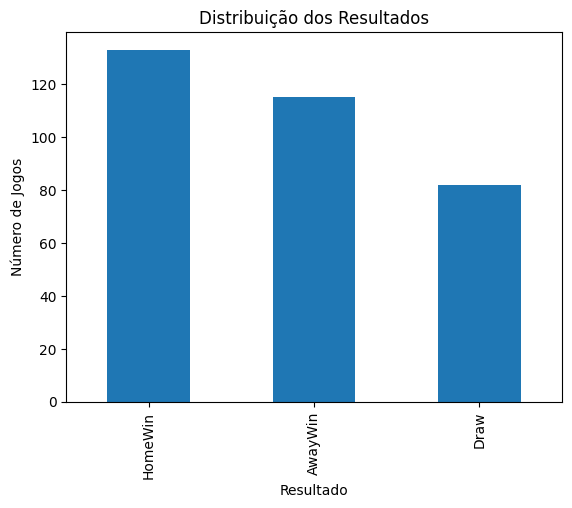

In [66]:
if 'Home_Goals' not in df.columns:
    print("A coluna 'Home_Goals' não foi criada ainda. Rode o primeiro code cell antes.")
else:
    # Cria a coluna de resultado com base nos gols
    df['Result'] = df.apply(
        lambda row: 'HomeWin' if row['Home_Goals'] > row['Away_Goals']
        else ('AwayWin' if row['Home_Goals'] < row['Away_Goals'] else 'Draw'),
        axis=1
    )

    # Verifica distribuição dos rótulos
    print(df['Result'].value_counts(normalize=True))

    # Visualiza com gráfico
    import matplotlib.pyplot as plt
    df['Result'].value_counts().plot(kind='bar')
    plt.title('Distribuição dos Resultados')
    plt.xlabel('Resultado')
    plt.ylabel('Número de Jogos')
    plt.show()


In [67]:
# Renomeia apenas as colunas xG
df = df.rename(columns={
    'xG': 'xG_Home',
    'xG.1': 'xG_Away'
})

# Limpa e separa o placar em duas colunas
df['Score_clean'] = df['Score'].apply(lambda x: re.sub(r'[^\d\-]', '-', str(x)))

# Filtra linhas com placar válido
df = df[df['Score_clean'].str.match(r'^\d+-\d+$')]

# Separa os gols em colunas distintas
df[['Home_Goals', 'Away_Goals']] = df['Score_clean'].str.split('-', expand=True)
df['Home_Goals'] = df['Home_Goals'].astype(int)
df['Away_Goals'] = df['Away_Goals'].astype(int)

# Cria coluna com total de gols
df['Total_Goals'] = df['Home_Goals'] + df['Away_Goals']



In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define features e target
features = df[['Home', 'Away', 'xG_Home', 'xG_Away']]
target = df['Total_Goals']

# Divide em treino e teste
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Preprocessador
categorical_features = ['Home', 'Away']
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')


In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Treina e prevê
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 1.19
RMSE: 1.51


In [70]:
# Média de xG quando o time joga em casa
xg_home_avg = df.groupby('Home')['xG_Home'].mean()

# Média de xG quando o time joga fora
xg_away_avg = df.groupby('Away')['xG_Away'].mean()


In [71]:
df_novos_jogos = pd.DataFrame({
    'Home': [
        'Chelsea', 'Brighton', 'Wolves', 'Southampton',
        'Newcastle Utd', 'Bournemouth', 'Liverpool'
    ],
    'Away': [
        'Everton', 'West Ham', 'Leicester City', 'Fulham',
        'Ipswich Town', 'Manchester Utd', 'Tottenham'
    ]
})


In [72]:
df_novos_jogos['xG_Home'] = df_novos_jogos['Home'].map(xg_home_avg)
df_novos_jogos['xG_Away'] = df_novos_jogos['Away'].map(xg_away_avg)
df_novos_jogos['Predicted_Total_Goals'] = model.predict(df_novos_jogos)
df_novos_jogos[['Home', 'Away', 'xG_Home', 'xG_Away', 'Predicted_Total_Goals']]


,Home,Away,xG_Home,xG_Away,Predicted_Total_Goals
0,Chelsea,Everton,2.02500,1.01250,2.82
1,Brighton,West Ham,1.64375,1.26875,2.98
2,Wolves,Leicester City,1.21875,0.83125,2.24
3,Southampton,Fulham,0.98750,1.41250,2.96
4,Newcastle Utd,Ipswich Town,1.75000,0.95000,2.26
5,Bournemouth,Manchester Utd,1.76250,1.15000,2.38
6,Liverpool,Tottenham,2.10625,1.47500,3.40


In [73]:
df_novos_jogos['Placar_Previsto'] = df_novos_jogos.apply(
    lambda row: f"{round(row['xG_Home'])} x {round(row['xG_Away'])}", axis=1
)


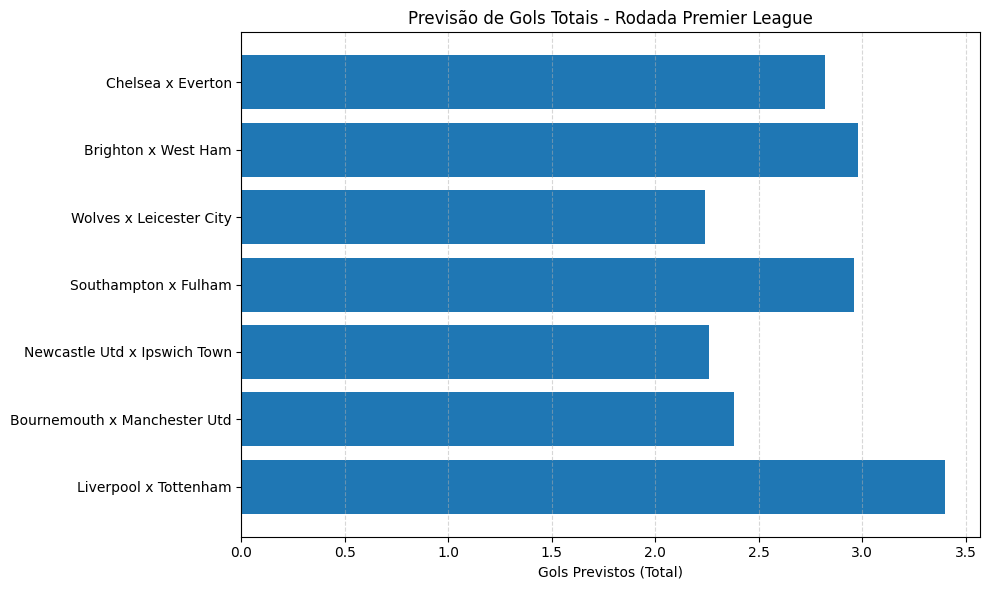

In [74]:
import matplotlib.pyplot as plt

# Rótulo da partida
df_novos_jogos['Match'] = df_novos_jogos['Home'] + ' x ' + df_novos_jogos['Away']

plt.figure(figsize=(10, 6))
plt.barh(df_novos_jogos['Match'], df_novos_jogos['Predicted_Total_Goals'])
plt.xlabel('Gols Previstos (Total)')
plt.title('Previsão de Gols Totais - Rodada Premier League')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


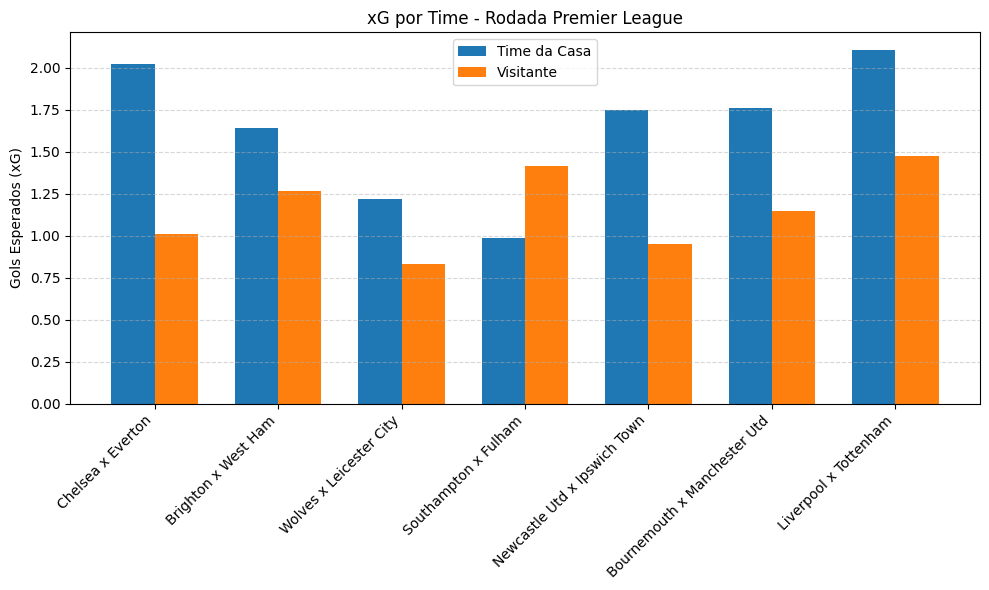

In [75]:
import numpy as np

plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(df_novos_jogos))

# Barras de xG dos times da casa e fora
plt.bar(index, df_novos_jogos['xG_Home'], bar_width, label='Time da Casa')
plt.bar(index + bar_width, df_novos_jogos['xG_Away'], bar_width, label='Visitante')

# Labels
plt.xticks(index + bar_width / 2, df_novos_jogos['Match'], rotation=45, ha='right')
plt.ylabel('Gols Esperados (xG)')
plt.title('xG por Time - Rodada Premier League')
plt.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


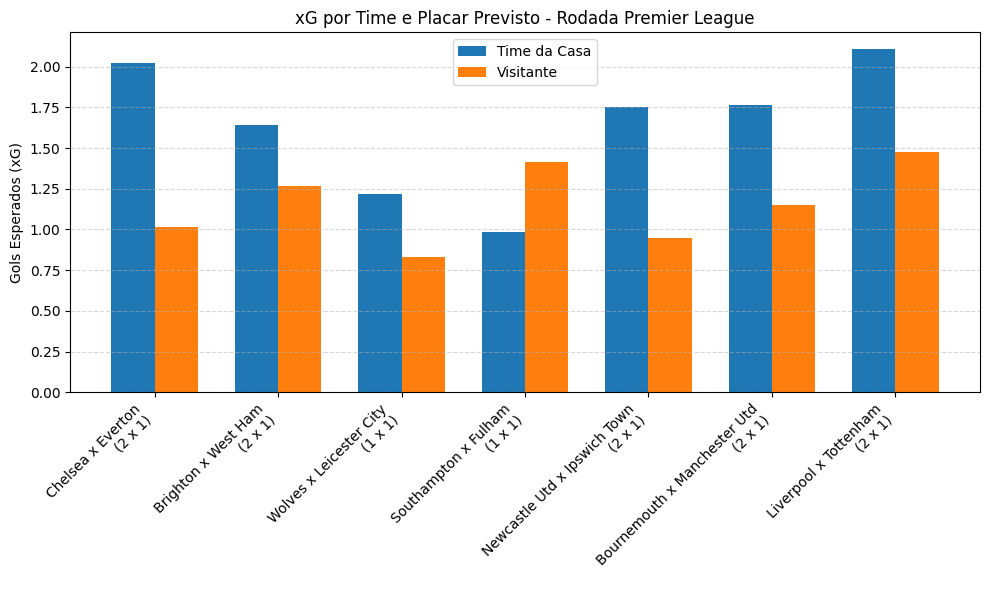

In [76]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(df_novos_jogos))

# Barras
plt.bar(index, df_novos_jogos['xG_Home'], bar_width, label='Time da Casa')
plt.bar(index + bar_width, df_novos_jogos['xG_Away'], bar_width, label='Visitante')

# Rótulos com placares previstos
match_labels = [
    f"{home} x {away}\n({placar})"
    for home, away, placar in zip(
        df_novos_jogos['Home'],
        df_novos_jogos['Away'],
        df_novos_jogos['Placar_Previsto']
    )
]

plt.xticks(index + bar_width / 2, match_labels, rotation=45, ha='right')
plt.ylabel('Gols Esperados (xG)')
plt.title('xG por Time e Placar Previsto - Rodada Premier League')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [77]:
df['Home'] = df['Home'].str.strip().str.lower()
df['Away'] = df['Away'].str.strip().str.lower()

home_avg_xG = df.groupby('Home')['xG_Home'].mean().reset_index()
away_avg_xG = df.groupby('Away')['xG_Away'].mean().reset_index()

home_avg_xG.columns = ['team', 'avg_home_xG']
away_avg_xG.columns = ['team', 'avg_away_xG']


In [78]:
df_treino = df[df['Score_clean'].str.contains(r'^\d+-\d+$', na=False)].copy()


In [79]:
df_treino = df_treino.merge(home_avg_xG, left_on='Home', right_on='team', how='left')
df_treino = df_treino.merge(away_avg_xG, left_on='Away', right_on='team', how='left')
df_treino.drop(columns=['team_x', 'team_y'], inplace=True)


In [83]:
from sklearn.ensemble import RandomForestRegressor
import joblib
import os

# Define os dados
X = df_treino[['avg_home_xG', 'avg_away_xG']]
y = df_treino['Home_Goals']

# Treina o modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Cria o caminho para salvar, independentemente da pasta atual
modelo_path = os.path.join(os.path.dirname(os.getcwd()), 'models', 'modelo_home_xg.pkl')

# Salva o modelo no local correto
joblib.dump(model, modelo_path)


['c:\\Users\\Daniel\\futebol-ml\\models\\modelo_home_xg.pkl']